In [33]:
import requests
import time
import pandas as pd
import geopandas as gpd
from shapely import Point, LineString
import matplotlib.pyplot as plt

In [2]:
# Obtenção da rota com a API ORS. openrouteservice.org/
ORS_API_KEY = 'iNs3rTy0uRt0K3nH3r3'

ponto_origem = (-28.6797, -49.3689) # Criciúma
ponto_destino = (-28.4015, -49.5505) # Serra

parametros = {
    'api_key': ORS_API_KEY,
    'start': '{},{}'.format(ponto_origem[1], ponto_origem[0]),
    'end': '{},{}'.format(ponto_destino[1], ponto_destino[0])
}

resposta = requests.get('https://api.openrouteservice.org/v2/directions/driving-car', params=parametros)

if resposta.status_code == 200:
    print('Request completada com sucesso.')
    dados = resposta.json()
else:
    print('Request falhou.')

Request completada com sucesso.


In [3]:
# Exportar rota como linha e abrir no GeoPandas
df = pd.DataFrame(dados['features'][0]['geometry']['coordinates'])
df.rename(columns = {0: 'long', 1: 'lat'}, inplace=True)

pnt_coord = [Point(x, y) for x, y in zip(df.long, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry = pnt_coord, crs = 'EPSG:4326')

line_path = LineString(gdf['geometry'])
line_gdf = gpd.GeoDataFrame(['Trajeto'], geometry = [line_path], crs = 'EPSG:4326')

In [4]:
cursos_dagua = gpd.read_file(r'C:\Users\Fernando\pythonGeoPandas\curso_dagua_sul.shp') # source: https://sigsc.sc.gov.br
cursos_dagua = cursos_dagua.to_crs('EPSG:4326')

In [5]:
# Obter pontos de intersecção de recursos hídricos.
interseccao = cursos_dagua.sjoin(line_gdf, how='inner', predicate='intersects') 
pontos_interseccao = interseccao.unary_union.intersection(line_gdf.unary_union)

In [28]:
intersec_gdf = gpd.GeoDataFrame(['Interseccao Trajeto x Rio'], geometry = [pontos_interseccao], crs = 'EPSG:4326')
intersec_gdf = intersec_gdf.explode(index_parts=False)
intersec_gdf = intersec_gdf.drop(0, axis = 1)
intersec_gdf = intersec_gdf.reset_index()
#intersec_gdf.rename(columns = {0: 'index'}, inplace=True)

In [7]:
#intersec_gdf.to_file(r'C:\Users\Fernando\pythonGeoPandas\pontos1.gpkg', driver='GPKG', layer='Pontos')

In [53]:
new_list = []

for i in range(len(intersec_gdf)):
    lat = intersec_gdf.geometry.y[i]
    long = intersec_gdf.geometry.x[i]
    resposta = requests.get('https://nominatim.openstreetmap.org/reverse?lat={}&lon={}&format=json'.format(lat, long))
    rjson = resposta.json()
    data_list = [rjson['name'], lat, long, intersec_gdf.geometry[i]]
    new_list.append(data_list)
    time.sleep(1)

In [70]:
df2 = pd.DataFrame(new_list)
df2.rename(columns = {0: 'Via', 1: 'lat', 2: 'long', 3: 'geom'}, inplace=True)

gdf2 = gpd.GeoDataFrame(df2[['Via', 'lat', 'long']], geometry = df2['geom'], crs = 'EPSG:4326')

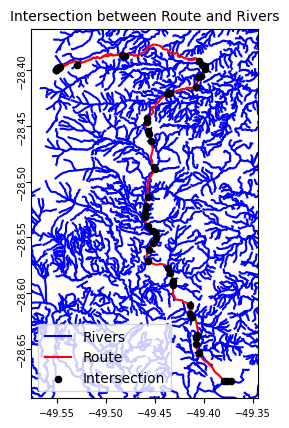

In [96]:
# Criando o mapa
fig, ax = plt.subplots()

cursos_dagua.plot(ax=ax, color='blue')
line_gdf.plot(ax=ax, color='red')
gdf2.plot(ax=ax, markersize=20, color='black', zorder=2)

bounds = line_gdf.geometry.total_bounds
xmin, ymin, xmax, ymax = bounds
ax.set_xlim([xmin*1.0005, xmax*0.9995])
ax.set_ylim([ymin*1.0005, ymax*0.9995])

plt.title('Intersection between Route and Rivers', fontsize=10)
plt.legend(['Rivers', 'Route', 'Intersection'])
plt.yticks(fontsize=7, rotation = 90, va='center', ha='center')
plt.xticks(fontsize=7)

fig.savefig(r'C:\Users\Fernando\pythonGeoPandas\outMap.png')

In [97]:
gdf2.head()

,Via,lat,long,geometry
0,Rodovia Luiz Tadeu Librelato,-28.414986,-49.407315,POINT (-49.40732 -28.41499)
1,SC-390,-28.394870,-49.401631,POINT (-49.40163 -28.39487)
2,Rodovia Luiz Tadeu Librelato,-28.443019,-49.457571,POINT (-49.45757 -28.44302)
3,Rodovia Luiz Tadeu Librelato,-28.420159,-49.434421,POINT (-49.43442 -28.42016)
4,Rodovia Governador Irineu Bornhausen,-28.386850,-49.480912,POINT (-49.48091 -28.38685)
